In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random
import seaborn as sns
sns.set()

In [258]:
data = loadmat('dataset.mat')

In [259]:
X = data['X']
x1 = np.array([i[0] for i in X])
x2 = np.array([i[1] for i in X])

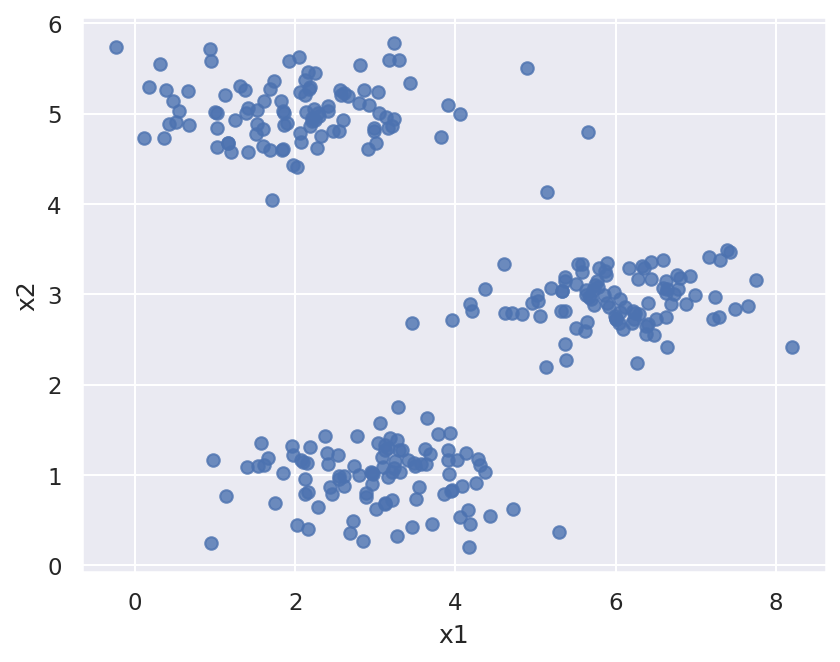

In [260]:
plt.figure(dpi=150)
plt.scatter(x1,x2,color='b',alpha=0.8)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [261]:
#预设聚类簇数k：请观察数据集散点图，预计聚类簇数k
k = 3

In [262]:
#随机选择数据集中k个点作为初始聚类中心
def init_centers(X,k):
    """
    输入：X:数据集(ndarray), k：预设的聚类簇数(int)
    输出：centers：初始化的中心集（建议：元素为ndarray的list)
    可能使用的函数：random.randint
    注意：需保证随机取的样本不重复
    """
    n_samples, n_features = X.shape
    centers = []
    
    selected_indices = np.random.choice(n_samples, k, replace=False)
    for index in selected_indices:
        centers.append(X[index])# 是把一整个样本都取出来了(一行数据)
        
    return centers

In [263]:
#向量欧氏距离计算，用于计算每个样本和中心的距离，可用于簇分配和代价函数计算
def distance(v1, v2):
    """
    输入：v1:样本(ndarray), v2:当前对应的中心(ndarray)
    输出：distance:欧氏距离(float/ndarray)
    """
    distance = np.sqrt(np.sum((v1 - v2) ** 2))
    return distance

In [264]:
#将样本分配到距离最近的中心所在的簇
def cluster_assignment(X, centers):
    """
    输入：X:数据集(ndarray), centers：当前中心集（建议：元素为ndarray的list)
    输出：assignment(建议：字典：key为簇标号、value为元素是ndarray的list)
    可能使用的函数：np.argmin
    注意：list和array在某些计算时的转换
    """
    assignment = {i:[] for i in range(len(centers))}
    # len(centers)返回的是列表的元素个数，每个ndarray是1个元素
    for sample in X:
        distances = [distance(sample, center) for center in centers]
        closest_center_index = np.argmin(distances)# 获取距离最近的中心的索引
        # 将样本分配到最近的中心所在的簇
        assignment[closest_center_index].append(sample)
    return assignment

In [265]:
#代价函数：所有数据点到当前对应中心的欧氏距离之和的平均值
def cost_function(assignment, centers):
    """
    输入：X:数据集(ndarray), centers：当前中心（建议：元素为ndarray的list)
    输出：cost:代价函数值（float/ndarray）
    可能使用的函数：np.argmin
    注意：list和array在使用np函数计算时的转换
    """
    total_cost = 0
    total_points = 0
    for i in range(len(centers)):
        for point in assignment[i]:
            total_cost += distance(point, centers[i])
            total_points += 1
    cost = total_cost / total_points if total_points > 0 else 0  
    return cost

In [266]:
#更新中心,满足停机条件（聚类中心不再改变）时结束更新
def center_update(assignment, centers):
    """
    输入：assignment(建议：字典：key为簇标号、value为元素是ndarray的list), centers：当前中心（建议：元素为ndarray的list)
    输出：new_centers:更新的中心集（建议：元素为ndarray的list), stop：停机条件标识（不停机：0/停机：1）
    可能使用的函数：np.mean
    注意：list和array在使用np函数计算时的转换
    """

    new_centers = []
    
    for k in range(len(centers)):
        cluster_points = assignment[k]
        
        if len(cluster_points) > 0:
            # 计算簇内所有点的均值作为新中心
            new_center = np.mean(cluster_points, axis=0)
        else:
            # 空簇保持原中心
            new_center = centers[k]
        
        new_centers.append(new_center)
        
        # 检查中心是否显著变化
        if np.linalg.norm(new_center - centers[k]) > 1e-6:
            stop = 0  
        else:
            stop = 1
    # 这里使用了numpy的linalg.norm函数来计算两个向量之间的欧氏距离
    # 两个向量的欧氏距离是指每个分量的差的平方和开根号
    # 如果欧氏距离大于1e-6(10^[-6])，则认为中心发生了显著变化
    # 如果所有中心都没有显著变化，则认为算法已经收敛，可以停止迭代
    return new_centers, stop

In [267]:
#聚类可视化
def plot_clustering(assignment, centers, epoch):
    color = ['r', 'b', 'c', 'g', 'k', 'w', 'y', 'm']
    plt.figure(dpi=150)

    # 1.绘制各个簇的样本点
    for k in range(len(centers)):
        cluster = np.array(assignment[k])
        # assignment[k]是包含当前簇所有ndarray样本的list，
        # np.array可以将一个list转换为同维度的ndarray，
        # 高维ndarray本身就是一层一层低维ndarray叠起来的，
        # 所以assignment[k]转换为ndarray后，
        # cluster的形状为(样本数, 特征数)
        if len(cluster) == 0:
            continue
        x1 = cluster[:,0]
        x2 = cluster[:,1]
        plt.scatter(x1, x2, c=color[k])
        # scatter可以通过给x,y传入数组来批量绘制所有点
        plt.xlabel('x1')
        plt.ylabel('x2')
    
    # 2.绘制中心点
    for k in range(len(centers)):
        x1 = centers[k][0] #centers列表的第k个ndarray的第一个元素，即横坐标
        x2 = centers[k][1] #centers列表的第k个ndarray的第二个元素，即纵坐标
        plt.scatter(x1, x2, c='k', marker = '*')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.title('epoch'+ str(epoch))
    plt.show()

In [268]:
#kmeans及可视化
def kmeans(X, k, max_epoch, plot=True):
    """
    输入：X:数据集(ndarray), k：预设的聚类簇数(int), max_epoch：最大训练轮数(int), plot:是否可视化（True/False)
    输出：assignment(建议：字典：key为簇标号、value为元素是ndarray的list), cost:最终的代价函数值，用于k-cost曲线的绘制（float/ndarray）
    注意：可视化只考虑了二维数据的情况，如需多维数据可视化请自行修改
    """
    centers = init_centers(X, k)
    
    for epoch in range(max_epoch):
        assignment = cluster_assignment(X, centers)
        
        # 不是epoch == max_epoch! range(max_epoch)是从0到max_epoch-1
        if plot and (epoch == 0 or epoch % 10 == 0 or epoch == max_epoch - 1):
            plot_clustering(assignment, centers, epoch)
            
        new_centers, stop = center_update(assignment, centers)
        
        if stop:
            print(f"Converged at epoch {epoch}")
            # 如果收敛了，显示最终结果
            if plot:
                plot_clustering(assignment, centers, f"Final")
            break
            
        centers = new_centers
    else:
        # for - else 结构
        # 如果达到最大迭代次数而没有收敛，即for循环正常结束没有遇到break
        if plot:
            plot_clustering(assignment, centers, f"Final (max epochs)")
    
    # 计算最终代价 - 使用当前的assignment和centers
    cost = cost_function(assignment, centers)
    
    return assignment, cost

In [269]:
max_epoch = 200 

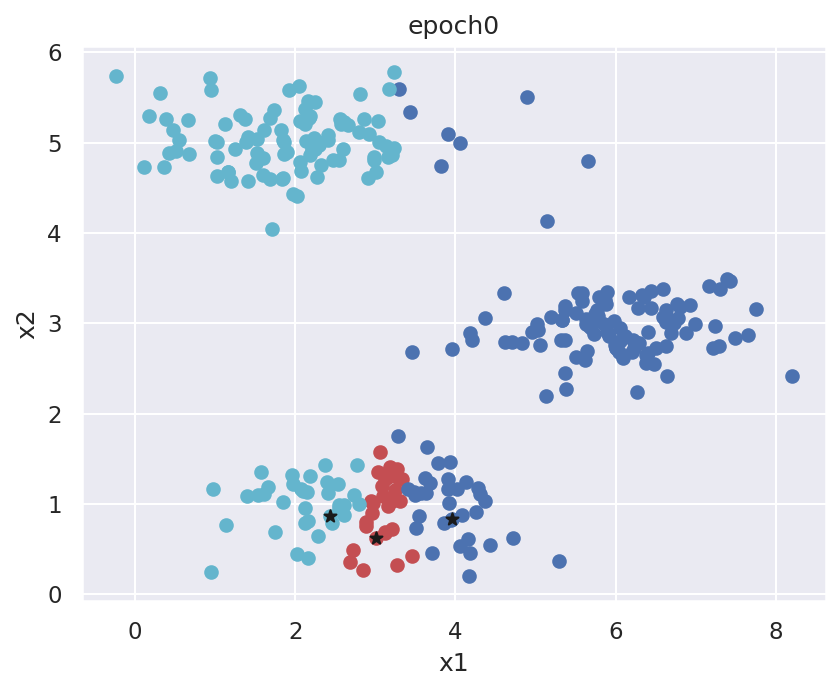

Converged at epoch 2


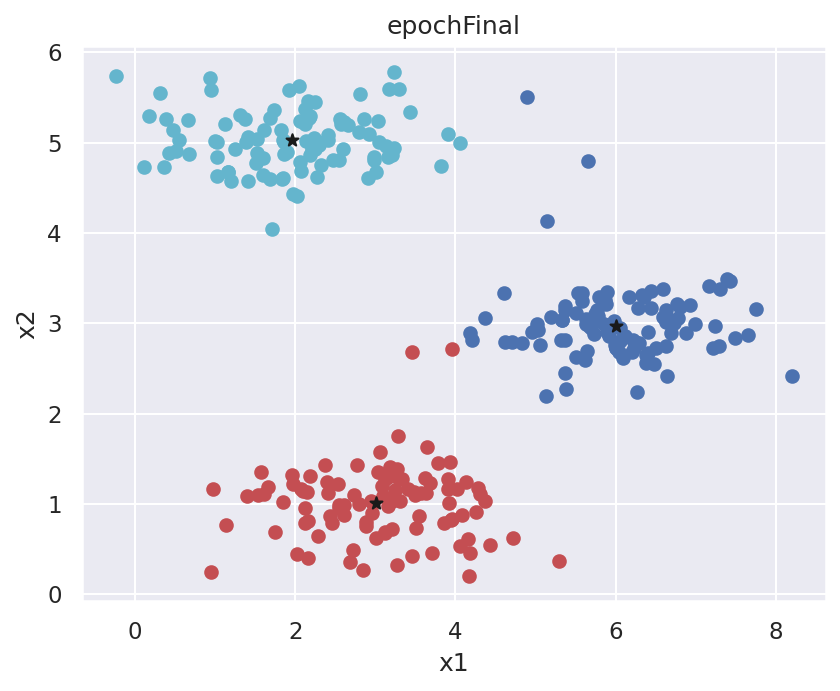

In [ ]:
assignment, _ = kmeans(X, k, max_epoch)# 不要cost,写了占位符

Converged at epoch 1
Converged at epoch 21
Converged at epoch 4
Converged at epoch 2
Converged at epoch 4


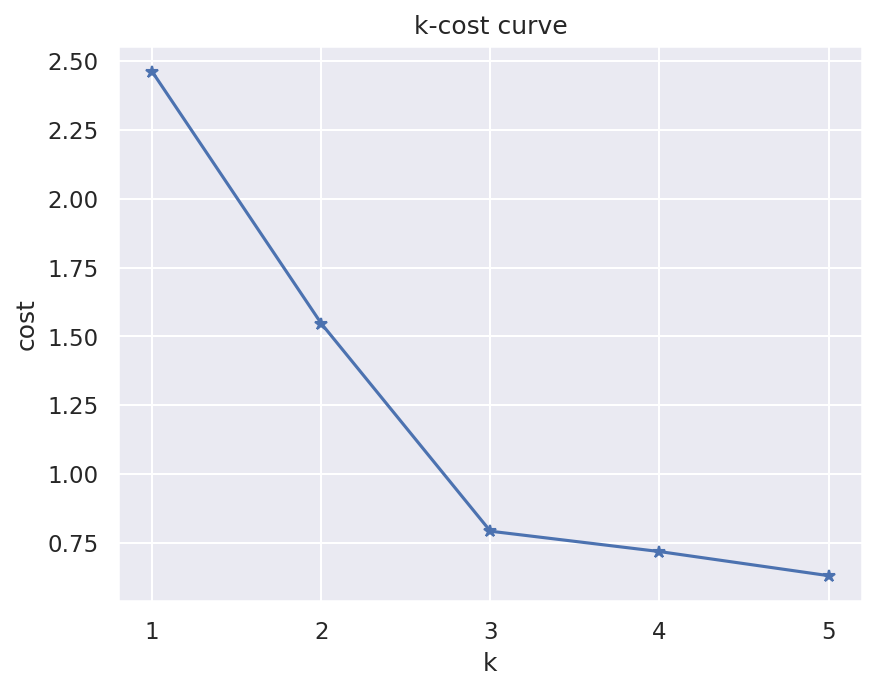

In [271]:
#绘制簇数-代价函数曲线：根据曲线，观察最合适的簇数k的选择
plt.figure(dpi=150)
Cost = []
max_k = 6
for k in range(1, max_k):
    _, cost = kmeans(X, k, max_epoch,False)
    Cost.append(cost)

plt.plot(range(1,max_k), Cost, c='b', marker = '*')
plt.xticks(range(1,max_k))
plt.xlabel('k')
plt.ylabel('cost')
plt.title('k-cost curve')
plt.show()